This notebook contains a rough guide to running analyses. 

To run, you need as a minimum
- an input file with data
- a genome fasta file
- a file of exons positions
- a function or class to score the mutations

The genome files and exon data can be downloaded from ensembl (see "Reference data" section below)

# Basic usage

In [1]:
from darwinian_shift import DarwinianShift, BigwigLookup

Welcome to JupyROOT 6.24/06


In [2]:
# Define a lookup to use. 
# This gives a score to each mutation. 
# The statistical tests will look for a difference between the null and observed distributions of these scores. 
# Here the scores come from a bigwig file of Phylop conservation scores
bw = BigwigLookup("tests/lookup_tests/phylop_bw_section.bw")

In [3]:
# Set up the project. This loads the mutation data and calculates the mutational spectrum.  
d = DarwinianShift(
    # For the mutation data input, can use a path to the tsv file, or pass a pandas dataframe of the mutations
    data="tests/test_data/test_mutation_data.tsv", 
    
    # This specifies the genome used.
    source_genome='GRCh37',  
    
    # This is the class the scores the mutations. Here it is Phylop conservation scores from a Bigwig file.  
    lookup=bw
)

In [4]:
# Run for a gene. This applies the scores to each mutation and runs the statistical tests. 
# The output is a Section object that stores the mutations and statistical results, 
# and has various plot functions (see Plotting results section below). 
notch3 = d.run_gene('NOTCH3')

In [5]:
# The mutations in the data which are in this gene/region can be seen in the observed_mutations dataframe. 
notch3.observed_mutations[['chr', 'pos', 'ref', 'mut', 'aachange', 'score']].head()

,chr,pos,ref,mut,aachange,score
0,19,15302358,C,T,G305S,7.760
1,19,15296298,C,A,G715V,6.697
2,19,15296398,G,T,L682I,1.209
3,19,15288563,G,C,C1392W,1.555
4,19,15299825,G,A,G451G,0.208


In [6]:
# And the null_mutations dataframe contain all possible mutations in the region. 
# This is used to generate the null model for the statistical tests
notch3.null_mutations[['pos', 'ref', 'mut', 'aachange', 'score']].head()

,pos,ref,mut,aachange,score
0,15311716,T,G,M1L,1.712
1,15311716,T,C,M1V,1.712
2,15311716,T,A,M1L,1.712
3,15311715,A,T,M1K,1.397
4,15311715,A,G,M1T,1.397


In [7]:
# Get p-values from any statistical tests
notch3.get_pvalues()

{'CDF_perm_glob_k3_pvalue': 0.00019998000199980003}

In [8]:
# Get a dictionary containing more details of the statistics
# In this case, 
# the conservation scores of the observed mutations are higher than the null (obs. mean=4.6 vs null mean=2.6)
# and this difference is statistically significant (p<0.0002)
notch3.get_results_dictionary()

{'gene': 'NOTCH3',
 'transcript_id': 'ENST00000263388',
 'chrom': '19',
 'section_id': 'ENST00000263388',
 'num_mutations': 294,
 'observed_median': 5.512500047683716,
 'observed_mean': 4.612350358798796,
 'expected_median_glob_k3': 1.805999994277954,
 'median_shift_glob_k3': 3.7065000534057617,
 'expected_mean_glob_k3': 2.6408225760543673,
 'mean_shift_glob_k3': 1.9715277827444289,
 'CDF_perm_glob_k3_num_smaller_or_equal': 10001,
 'CDF_perm_glob_k3_num_larger_or_equal': 1,
 'CDF_perm_glob_k3_pvalue': 0.00019998000199980003,
 'CDF_perm_glob_k3_cdf_mean': 0.660720474107507}

# Reference data

A reference genome and a file with exon start and end locations is required to run the analysis.   
These can be downloaded from ensembl.   

This can be done manually, or a couple of functions are available to automatically download the requested files.  

## Reference genome files

These fasta files need to be compressed using bgzip and indexed using samtools faidx.   
If downloading a .fa.gz file, first unzip before recompressing and indexing:   
```
> gunzip assembly.fa.gz
> bgzip assembly.fa
> samtools faidx assembly.fa.gz
```

This compressing and indexing is done as part of the download functions described below. 

## Exon file formats

The file of exon locations can be downloaded from Ensembl Biomart (or using one of the functions described below).   
The required columns are:
- Gene stable ID
- Transcript stable ID
- Chromosome/scaffold name
- Strand
- CDS Length
- Exon rank in transcript
- Genomic coding start
- Genomic coding end
- Gene name

In [9]:
# Example file
import pandas as pd
pd.read_csv("tests/test_data/test_exon_data.tsv", sep="\t").head()

,Gene stable ID,Transcript stable ID,Chromosome/scaffold name,Strand,CDS Length,Exon rank in transcript,Genomic coding start,Genomic coding end,Gene name
0,ENSG00000130522,ENST00000600972,19,-1,500.0,1,18391266.0,18391739.0,JUND
1,ENSG00000130522,ENST00000600972,19,-1,500.0,2,18390829.0,18390854.0,JUND
2,ENSG00000130522,ENST00000252818,19,-1,1044.0,1,18391251.0,18392294.0,JUND
3,ENSG00000130520,ENST00000593829,19,-1,420.0,1,18433828.0,18433830.0,LSM4
4,ENSG00000130520,ENST00000593829,19,-1,420.0,2,18426834.0,18426875.0,LSM4


## Functions to download the reference data

There are a couple of functions available to download reference files and store in the `darwinian_shift/reference_data` directory   

These are set up to download GRCh37 or the latest version of a genome for a given species.   
Files can be downloaded manually for any other cases.   

In [10]:
from darwinian_shift import download_reference_data_from_latest_ensembl, download_grch37_reference_data

In [11]:
# This will download the human genome reference GRCh37 and a file of exon locations
# download_grch37_reference_data()

In [12]:
# Or use this function to get the latest version of a particular genome and the accompanying exon locations 
# For example, for mouse
# download_reference_data_from_latest_ensembl('mus_musculus')

## Different ways of specifying reference data

There are few options for specifying the reference data files.   
If the reference data does not match the mutation data, errors will be raised or warnings given.   

In [13]:
# Specify the source genome:
# (This likely won't work unless you have downloaded the mouse reference data using the function above)
d = DarwinianShift(
    data="tests/test_data/mouse_muts.tsv", 
    source_genome='mus_musculus'
)

In [14]:
# Alternatively, file paths for the reference data and the exon data can be given
# This allows any fasta and exon file to be used. 
# (The file paths might need adjusting, depending on which ensembl version was used)
d = DarwinianShift(
    data="tests/test_data/mouse_muts.tsv", 
    reference_fasta="darwinian_shift/reference_data/mus_musculus/ensembl-99/Mus_musculus.GRCm38.dna.primary_assembly.fa.gz",
    exon_file="darwinian_shift/reference_data/mus_musculus/ensembl-99/biomart_exons_mus_musculus.txt"
)

In [15]:
# Can also specify the ensembl release, which can be useful if genomes from multiple releases are downloaded:
d = DarwinianShift(
    data="tests/test_data/mouse_muts.tsv", 
    source_genome='mus_musculus',
    ensembl_release=99
)

In [16]:
# Human GRCh37 is a special case that can be called like this 
d = DarwinianShift(
    data="tests/test_data/test_mutation_data.tsv", 
    source_genome='GRCh37'
)

# Mutation data file

The data argument can either be the path to a tab-separated file, or a pandas dataframe.   
The only columns required are "chr", "pos", "ref" and "mut". The column order does not matter, but those names must be the column headings.  

In [17]:
# Example mutations in a tab separated file
data=pd.read_csv("tests/test_data/test_mutation_data.tsv", sep="\t")
data.head()

,sampleID,chr,pos,ref,mut
0,PD30272ac,19,15302358,C,T
1,PD30272ae,19,15296298,C,A
2,PD30272ah,19,15296398,G,T
3,PD30272aj,19,15288563,G,C
4,PD30272aw,19,15299825,G,A


# More options for running

Various options can be selected when either setting up the project or running analysis on an individual gene/region

In [18]:
from darwinian_shift import CDFPermutationTest, CDFZTest, BinomTest, PermutationTest
from darwinian_shift import GlobalKmerSpectrum, TranscriptKmerSpectrum, EvenMutationalSpectrum
from darwinian_shift import StructureDistanceLookup
import numpy as np

In [19]:
d = DarwinianShift(
    data="tests/test_data/test_mutation_data.tsv", 
    source_genome='GRCh37',  
    lookup=bw
)

In [20]:
# There are many additional options that can be used when running analysis. 
print(d.run_gene.__doc__)


        Run analysis for a single gene
        :param gene:  Gene name.
        :param plot: Will plot the standard results of the analysis. If False, can still be plotted afterwards from
        the returned class object. Plotting afterwards also enables more plotting options.
        :param spectra: The mutational spectrum or spectra to use for the analysis. If None, will use the spectra
        of the project.
        :param statistics: The statistical tests to run. If None, will use the statistics of the project.
        :param start: Will exclude residues before this one from the analysis. If None, will start from the first
        residue of the protein.
        :param end: Will exclude residues after this one from the analysis. If None, will end at the last
        residue of the protein.
        :param excluded_mutation_types: Can be string or list of strings. Mutation types to exclude from the
        analysis. E.g. ['synonymous', 'nonsense']. If None, will use the excluded_m

In [21]:
# For example, the analysis does not have to be run over whole genes. 
# It can be run for a section of a gene, here residues 300-500
notch3_section = d.run_gene(gene='NOTCH3',start=300, end=500)

In [22]:
# The analysis can also be run by specifying the transcript id, rather than the gene name
notch3_263388 = d.run_transcript(transcript_id='ENST00000263388',start=300, end=500)

In [23]:
# Options can be set at the start to apply to the whole project
d2 = DarwinianShift(
    # The basic options as before
    data="tests/test_data/test_mutation_data.tsv",
    source_genome='GRCh37',
    lookup=bw,
    
    # A list of the statistical tests to be run can be given, see "Statistical tests" below
    statistics=[CDFPermutationTest(), CDFZTest(), BinomTest()],
    
    # MutationalSpectrum options, see "Mutational spectrum" below
    spectra=[GlobalKmerSpectrum(), TranscriptKmerSpectrum(k=1), EvenMutationalSpectrum()],  
    
    # Options for defining the genes/transcripts to be run
    # These are used to calculate the mutational spectrum, and if d.run_all() is used. 
    # Either a list of gene names or a list of transcripts can be given.
    gene_list=None,  
    transcript_list=None,
    
    # If not using the transcript_list, use_longest_transcript_only determines whether to run for all 
    # transcripts in each gene, or just the longest one. 
    # Warning, if running more than one transcript per gene, mutations may be double counted in the mutational spectrum
    # In that case, spectra can be precalculated with use_longest_transcript_only=True (see "Mutational spectrum" below)
    use_longest_transcript_only=True,
    
    # Can remove duplicate mutations (same chromosome, position, reference base and mutated base)
    deduplicate=False,

    # Options to exclude certain mutations from all tests. 
    # These will exclude from the tests, not the mutational spectrum.
    excluded_positions=None,  # dict, key=chrom, val=positions. E.g. {'1': [1, 2, 3]}
    excluded_mutation_types=None,   # E.g. "synonymous", "missense", "nonsense". Can be string or list
    included_mutation_types=None,   # E.g. "synonymous", "missense", "nonsense". Can be string or list
    
    verbose=True   # Will print out a bit more information as it runs.  
)

exon_file: /Users/mh28/PycharmProjects/darwinian_shift/darwinian_shift/reference_data/homo_sapiens/ensembl-99/GRCh37/biomart_exons_homo_sapiens.txt
reference_fasta: /Users/mh28/PycharmProjects/darwinian_shift/darwinian_shift/reference_data/homo_sapiens/ensembl-99/GRCh37/Homo_sapiens.GRCh37.dna.primary_assembly.fa.gz
3 genes
KEAP1:ENST00000171111 NOTCH3:ENST00000263388 AKT2:ENST00000392038 
48 mutations not in used transcripts, of which 0 are exonic in an alternative transcript


In [24]:
# Alternatively, options can be set for individual analyses
notch3 = d.run_gene('NOTCH3', 
                    statistics=[CDFZTest(), PermutationTest(stat_function=np.median)],
                    included_mutation_types=['synonymous', 'missense'],
                    lookup=bw
                   )

In [25]:
# d.run_section takes a dictionary for an argument which can be used to define many options for running. 
# These options can be passed to run_gene or run_transcript, 
# but run_section can be useful if wanting to run through a list of analyses with different options. 
notch3_section = d.run_section(
    {
        # The gene name or transcript id is required
        # 'gene': 'NOTCH3', 
        'transcript_id': 'ENST00000263388',
     
        # Can name the section
        'section_id': 'notch3_sectionA',

        # Can define the start and end residues of the analysed region
        'start': 1378,
        'end': 1640,

        # Can define the pdb id and chain for structural analysis
        'pdb_id':'4ZLP', 'pdb_chain':'A',

        # Can define the mutation types to include or exclude
        'included_mutation_types':'missense',
        # excluded_mutation_types=['synonymous', 'nonsense'],

        # Can include or exclude certain residues from the analysis
        'excluded_residues': [1400, 1401, 1408, 1409],
        # included_residues = [...],

        # the lookup to use can be defined and can be different from the project lookup, see "Changing lookup" below
        'lookup': StructureDistanceLookup(pdb_directory='tests/test_data/', 
                                          sifts_directory='tests/test_data/'),
     
     
        # Any additional attributes can be added that are required for the lookup
        'target_selection' :"protein and segid A and resid 1531 1532"
    }
)


In [26]:
# It is also possible to run the analysis for every gene in the dataset
# (However, in this example the Bigwig file only contains data for NOTCH3, so the other genes cannot be run)
d.run_all()
d.results[['gene', 'num_mutations', 'expected_mean_glob_k3', 'observed_mean', 'CDF_perm_glob_k3_pvalue']]

NoMutationsError No scores for ENST00000171111 KEAP1 - Unable to run for ENST00000171111
NoMutationsError No scores for ENST00000392038 AKT2 - Unable to run for ENST00000392038


,gene,num_mutations,expected_mean_glob_k3,observed_mean,CDF_perm_glob_k3_pvalue
0,NOTCH3,294,2.640823,4.61235,0.0002


# Plotting results

In [27]:
notch3_section = d.run_section({'gene': 'NOTCH3', 'start': 300, 'end': 500 })

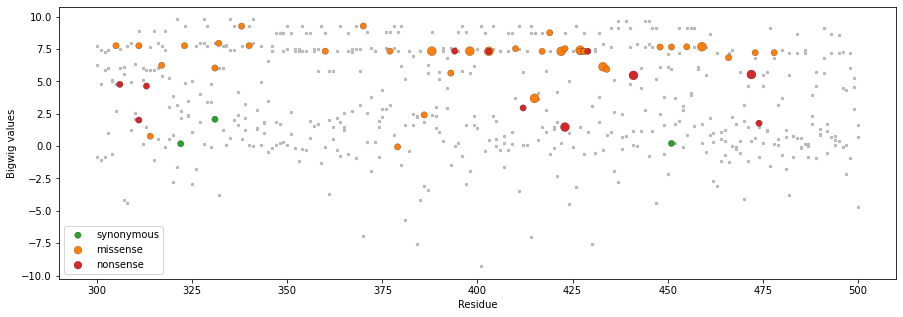

In [28]:
# Can plot the position and score of every mutation. 
notch3_section.plot_scatter(base_marker_size=40, unmutated_marker_size=10)

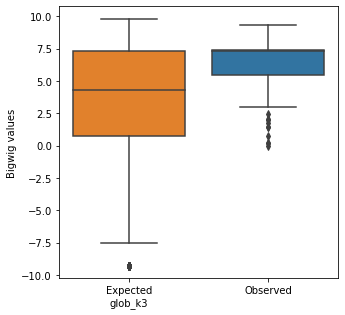

In [29]:
# Boxplots of the distribution of expected and observed scores
notch3_section.plot_boxplot()

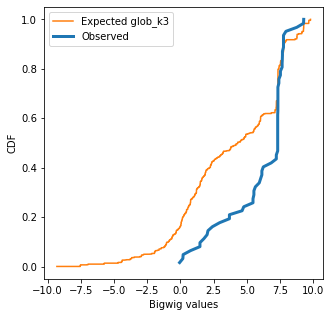

In [30]:
# Can plot expected and observed cumulative distributions 
notch3_section.plot_cdfs()

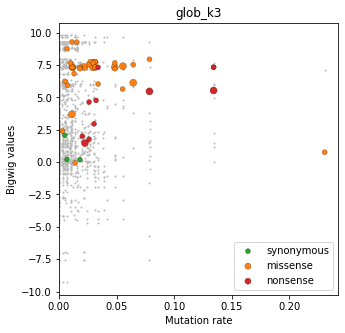

In [31]:
# Can plot the expected mutation rate (arbitrary units) against the score
notch3_section.plot_mutation_rate_scatter(base_marker_size=25)

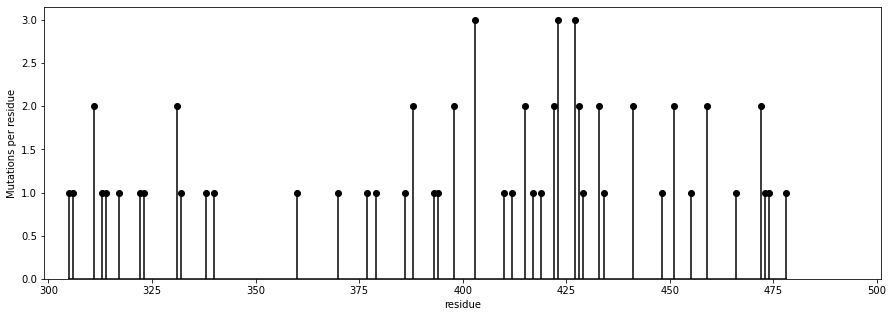

In [32]:
# Can plot the number of mutations observed on each residue
notch3_section.plot_lollipop()

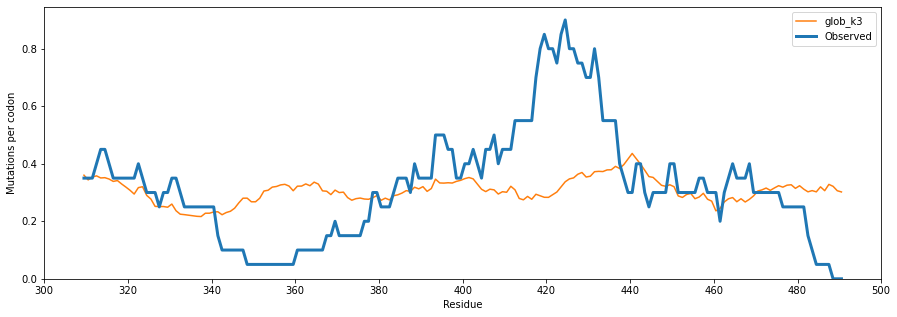

In [33]:
# Can plot a sliding window with the expected and observed mutation density. 
notch3_section.plot_sliding_window()

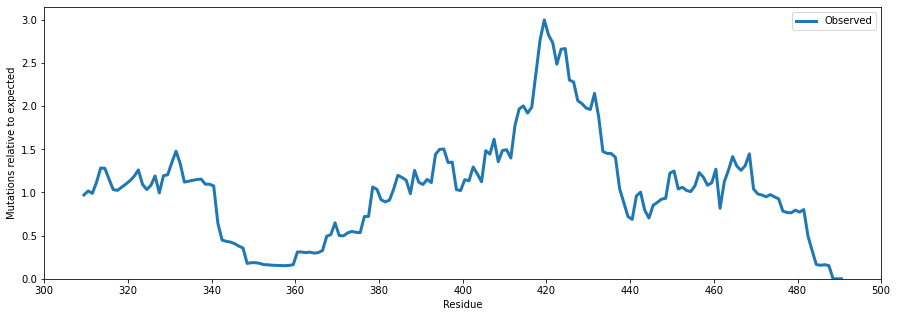

In [34]:
# Can also plot a sliding window with observed mutation density relative to the expected. 
notch3_section.plot_sliding_window(divide_by_expected_rate=True)

# Lookup classes

These are classes that lookup the given metric for every possible mutation in the given region.  
E.g. FoldXLookup assigns the ∆∆G value calculated from FoldX to each mutation in the pdb structure.  

The classes are passed a Section object when called and can use any attributes of the object to lookup/calculate the metric. (The Section class is used to represent a gene, or section of a gene to be analysed). 

A selection of lookup classes are available to use, but any function or class can be used as long as:
- it takes a Section object as an argument to `__call__`
- it returns an array of values for each of the mutations in the null_mutations dataframe of the Section.

There are various lookup classes available in the `darwinian_shift/lookup_classes/` directory.   
Some guidance on how to use each lookup class can be seen in the docstrings.  

In [35]:
from darwinian_shift import FoldXLookup

In [36]:
FoldXLookup?

In [37]:
# The basic structure of lookup class is like this

class MyLookup:
    """
    Returns the remainder after the residue number is divided by 3. 
    """
    
    def __init__(self, name='MyLookup'):
        self.name = name
        
    def __call__(self, section_object):
        return (section_object.null_mutations['residue'] % 3).astype(float)

In [38]:
mylook = MyLookup()

In [39]:
sec = d.run_gene('NOTCH3', lookup=mylook)  # Runs analysis using the new lookup (see Changing Lookup below)

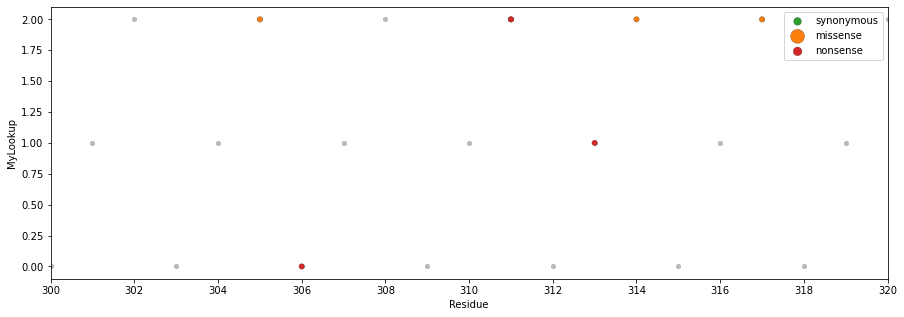

In [40]:
# You can see the score of each mutation is now based on the residue number. 
sec.plot_scatter(xlim=[300, 320], base_marker_size=30, unmutated_marker_size=20)

In [41]:
# Now to make the lookup slightly more complex to demonstrate how to use arbitrary attributes of Sections
class MyLookup2:
    """
    Returns the remainder after the residue number is divided by a given number (name divisor). 
    """
    
    def __init__(self, name='MyLookup'):
        self.name = name
        
    def __call__(self, section_object):
        # Use the section_object.divisor attribute to divide the residue number and give a score
        return (section_object.null_mutations['residue'] % section_object.divisor).astype(float)

In [42]:
mylook2 = MyLookup2()

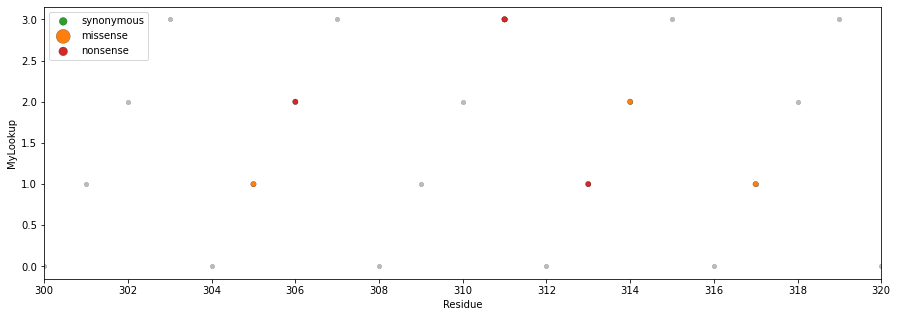

In [43]:
# Run gene can be given the required divisor attribute. 
# Any additional attributes can be defined in this way and accessed in a lookup class. 
sec = d.run_gene(gene='NOTCH3', divisor=4, lookup=mylook2)  
sec.plot_scatter(xlim=[300, 320], base_marker_size=30, unmutated_marker_size=20)

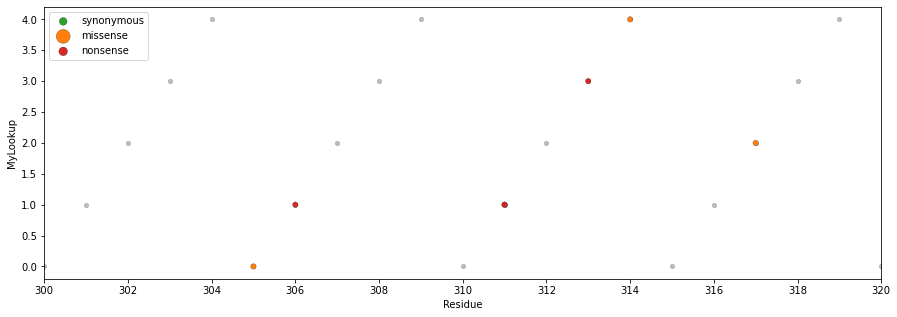

In [44]:
# And the analysis can be run with a different divisor, but without having to use another lookup
sec = d.run_gene(gene='NOTCH3', divisor=5, lookup=mylook2)  
sec.plot_scatter(xlim=[300, 320], base_marker_size=30, unmutated_marker_size=20)

# Changing lookup

You can change the scoring applied to the mutations without having to reload the data and recalculate the mutational spectrum.  

In [45]:
from darwinian_shift import ClinvarLookup

In [46]:
# This is a lookup that matches against variants in Clinvar
cl = ClinvarLookup(clinvar_variant_summary_file="tests/test_data/clinvar_sample.txt", 
                   assembly="GRCh37")

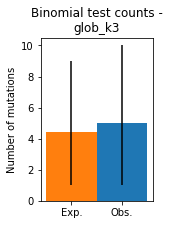

In [47]:
# The lookup can be assigned when running an individual analysis, and it overrides the lookup attached to the project
notch3_cl = d.run_gene("NOTCH3", lookup=cl)
# In this case, the number of Clinvar matching mutations is roughly what would be expected under neutral selection
notch3_cl.plot_binomial(binom_test=BinomTest(), show_legend=False)

In [48]:
# Alternatively, the lookup of the whole project can be changed
d.change_lookup(cl, inplace=True)

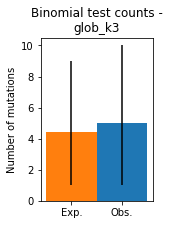

In [49]:
# Now this runs with the Clinvar lookup
notch3_cl2 = d.run_gene('NOTCH3')
notch3_cl2.plot_binomial(binom_test=BinomTest(), show_legend=False)

# More complex lookup usage

Lookups can be used in combination.    

The ANDLookup tests for enrichment of mutations that are part of multiple categories.    
The ORLookup tests for enrichment of mutations that are in any of multiple categories.   
And the MutationExclusionLookup can be used to exclude certain categories of mutations, then use a different lookup to test within the remaining mutations.  

In [50]:
from darwinian_shift import ANDLookup, ORLookup, MutationExclusionLookup

In [51]:
# Test for enrichment of mutations with high conservation and that are pathogenic/likely pathogenic in Clinvar
# Any mutations with a conservation score over 2 and that are also in Clinvar will have a score of 1, 
# all other mutations will have a score of zero. 
AND = ANDLookup(lookups=[bw, cl],  # Use the two lookups defined earlier
                directions=[1, 1],  # Will include mutations above the thresholds. -1 would include mutations below the threshold. 
               thresholds=[2, 0.5]  # The threshold scores for the two lookups
               )
notch3_and = d.run_gene('NOTCH3', lookup=AND, statistics=BinomTest())  # Use the binomial test (see below)
notch3_and.get_results_dictionary()

{'gene': 'NOTCH3',
 'transcript_id': 'ENST00000263388',
 'chrom': '19',
 'section_id': 'ENST00000263388',
 'num_mutations': 294,
 'observed_median': 0.0,
 'observed_mean': 0.017006802721088437,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 0.0,
 'expected_mean_glob_k3': 0.0129465540074567,
 'mean_shift_glob_k3': 0.004060248713631738,
 'binom_glob_k3_pvalue': 0.4384357075150863,
 'binom_glob_k3_expected_proportion': 0.012946554007456697,
 'binom_glob_k3_observed_proportion': 0.017006802721088437,
 'binom_glob_k3_expected_count': 3.806286878192269,
 'binom_glob_k3_observed_count': 5,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 8.0,
 'binom_glob_k3_expected_CI_low': 1.0,
 'binom_glob_k3_observed_CI_low': 1.0,
 'binom_glob_k3_observed_CI_high': 10.0}

In [52]:
# Test for enrichment of mutations with either a high conservation score or that are Clinvar pathogenic (or both)
# Any mutations with a conservation score over 2 or that are in Clinvar will have a score of 1, 
# all other mutations will have a score of zero. 
OR = ORLookup(lookups=[bw, cl],  # Use the two lookups defined earlier
                directions=[1, 1],  # Will include mutations above the thresholds. -1 would include mutations below the threshold. 
               thresholds=[2, 0.5]  # The threshold scores for the two lookups
               )
notch3_or = d.run_gene('NOTCH3', lookup=OR, statistics=BinomTest())  # Use the binomial test (see below)
notch3_or.get_results_dictionary()

{'gene': 'NOTCH3',
 'transcript_id': 'ENST00000263388',
 'chrom': '19',
 'section_id': 'ENST00000263388',
 'num_mutations': 294,
 'observed_median': 1.0,
 'observed_mean': 0.7142857142857143,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 1.0,
 'expected_mean_glob_k3': 0.4825788853371132,
 'mean_shift_glob_k3': 0.23170682894860112,
 'binom_glob_k3_pvalue': 1.0342701840453376e-15,
 'binom_glob_k3_expected_proportion': 0.4825788853371133,
 'binom_glob_k3_observed_proportion': 0.7142857142857143,
 'binom_glob_k3_expected_count': 141.8781922891113,
 'binom_glob_k3_observed_count': 210,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 159.0,
 'binom_glob_k3_expected_CI_low': 125.0,
 'binom_glob_k3_observed_CI_low': 195.0,
 'binom_glob_k3_observed_CI_high': 225.0}

In [53]:
# Test for enrichment of Clinvar pathogenic mutations only within mutations with a high conservation score
EXCL = MutationExclusionLookup(
    exclusion_lookup=bw, 
    exclusion_direction=-1,  # Will exclude mutations below the threshold. 1 would exclude mutations above the threshold. 
    exclusion_threshold=2,  # The threshold score for the bw lookup
    lookup=cl                               
)
notch3_excl = d.run_gene('NOTCH3', lookup=EXCL, statistics=BinomTest())  # Use the binomial test (see below)
notch3_excl.get_results_dictionary()

# Note that 'num_mutations' is now lower, because some mutations (those with a high conservation score) 
# have been excluded from the test

{'gene': 'NOTCH3',
 'transcript_id': 'ENST00000263388',
 'chrom': '19',
 'section_id': 'ENST00000263388',
 'num_mutations': 210,
 'observed_median': 0.0,
 'observed_mean': 0.023809523809523808,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 0.0,
 'expected_mean_glob_k3': 0.026948165653441925,
 'mean_shift_glob_k3': -0.003138641843918117,
 'binom_glob_k3_pvalue': 1.0,
 'binom_glob_k3_expected_proportion': 0.026948165653441925,
 'binom_glob_k3_observed_proportion': 0.023809523809523808,
 'binom_glob_k3_expected_count': 5.659114787222804,
 'binom_glob_k3_observed_count': 5,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 11.0,
 'binom_glob_k3_expected_CI_low': 2.0,
 'binom_glob_k3_observed_CI_low': 1.0,
 'binom_glob_k3_observed_CI_high': 10.0}

# Statistical tests

A number of statistical tests are available. The most appropriate test to use will depend on the data.   
The tests to use can be defined at the start of the project or when running an analysis of a gene/region.  

In [54]:
from darwinian_shift import CDFPermutationTest, CDFZTest, BinomTest, ChiSquareTest, PermutationTest, KSTest

In [55]:
notch3_section = d.run_gene(
    "NOTCH3", lookup=bw, 
    statistics=[
        # A permutation test using the CDF value of the scores. 
        # Less sensitive to outliers than a permutation test using the mean score
        CDFPermutationTest(num_permutations=10000), 
        
        # A normal approximation of the CDF permutation test. Faster, but not applicable in all cases. 
        CDFZTest(), 
        
        # For categorical scores, can use a chi-square test, defining the bins
        # May give value error if some scores (observed or not) are outside the bin range
        ChiSquareTest(bins=[-11, 0, 5, 10]),
        
        # A permutation test using any function that can be applied to the mutation scores (an array of floats). 
        # Here using median
        PermutationTest(stat_function=np.median),
        
        # A Kolmogorov-Smirnov test. May not be appropriate if there are many mutations with identical scores. 
        KSTest()
    ]
)
notch3_section.get_pvalues()

{'CDF_perm_glob_k3_pvalue': 0.00019998000199980003,
 'CDF_Z_glob_k3_pvalue': 1.3438847937855815e-21,
 'chi_square_glob_k3_pvalue': 1.519244288694345e-21,
 'median_perm_glob_k3_pvalue': 0.00019998000199980003,
 'ks_glob_k3_pvalue': 2.1393179139055308e-16}

In [56]:
# Some statistical tests return additional information in the results dictionary
notch3_section.get_results_dictionary()

{'gene': 'NOTCH3',
 'transcript_id': 'ENST00000263388',
 'chrom': '19',
 'section_id': 'ENST00000263388',
 'num_mutations': 294,
 'observed_median': 5.512500047683716,
 'observed_mean': 4.612350358798796,
 'expected_median_glob_k3': 1.805999994277954,
 'median_shift_glob_k3': 3.7065000534057617,
 'expected_mean_glob_k3': 2.6408225760543673,
 'mean_shift_glob_k3': 1.9715277827444289,
 'CDF_perm_glob_k3_num_smaller_or_equal': 10001,
 'CDF_perm_glob_k3_num_larger_or_equal': 1,
 'CDF_perm_glob_k3_pvalue': 0.00019998000199980003,
 'CDF_perm_glob_k3_cdf_mean': 0.660720474107507,
 'CDF_Z_glob_k3_pvalue': 1.3438847937855815e-21,
 'CDF_Z_glob_k3_cdf_mean': 0.660720474107507,
 'chi_square_glob_k3_statistic': 95.87214784028309,
 'chi_square_glob_k3_pvalue': 1.519244288694345e-21,
 'chi_square_glob_k3_low_count_warning': False,
 'chi_square_glob_k3_bins': [-11, 0, 5, 10],
 'chi_square_glob_k3_observed_counts': array([ 17, 123, 154]),
 'chi_square_glob_k3_expected_counts': array([ 55.86218769, 155.

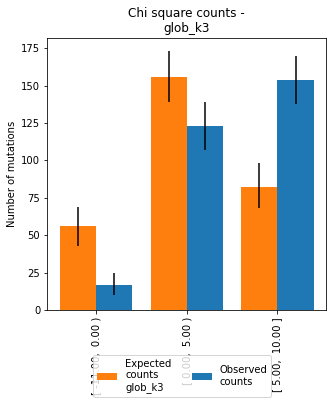

In [57]:
# The results of the chi-sq test can be plotted
notch3_section.plot_binned_counts(figsize=(5, 5))

{'gene': 'NOTCH3',
 'transcript_id': 'ENST00000263388',
 'chrom': '19',
 'section_id': 'ENST00000263388',
 'num_mutations': 294,
 'observed_median': 0.0,
 'observed_mean': 0.017006802721088437,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 0.0,
 'expected_mean_glob_k3': 0.015145914584191665,
 'mean_shift_glob_k3': 0.0018608881368967715,
 'binom_glob_k3_pvalue': 0.6363819410987945,
 'binom_glob_k3_expected_proportion': 0.015145914584191664,
 'binom_glob_k3_observed_proportion': 0.017006802721088437,
 'binom_glob_k3_expected_count': 4.452898887752349,
 'binom_glob_k3_observed_count': 5,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 9.0,
 'binom_glob_k3_expected_CI_low': 1.0,
 'binom_glob_k3_observed_CI_low': 1.0,
 'binom_glob_k3_observed_CI_high': 10.0}

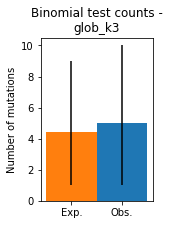

In [58]:
# For scores which have only two values (e.g. true or false), a binomial test can be used
notch3_cl = d.run_gene("NOTCH3", lookup=cl, statistics=BinomTest())
notch3_cl.plot_binomial(show_legend=False)
notch3_cl.get_results_dictionary()

# Mutational spectrum

The null distribution is calculated based on the mutational spectrum.  
This spectrum can be defined in a few different ways, and must be specified at the start of a project.  

The spectra are based on the nucleotide change and the surrounding context bases. The size of the context region can be adjusted.   

The default option is a trinucleotide spectrum calculated from all exonic single nucleotide mutations in the data (or in the subset of data defined by the gene_list or transcript_list).   

In [59]:
# Set up the project. This loads the mutation data and calculates the mutational spectrum.  
d_spec = DarwinianShift(
    data="tests/test_data/test_mutation_data.tsv", 
    source_genome='GRCh37',  
    lookup=bw,
    
    statistics=[CDFPermutationTest(testing_random_seed=0)],
    
    # Multiple spectra can be run at the same time.  
    spectra=[
        # a spectrum calculated from all of the data. 
        # This will used to calculated the null for all genes/regions.
        # k=3 means a trinucleotide signature (one context base on either side of the nucleotide change)
        GlobalKmerSpectrum(k=3),  
        
        # a spectrum calculated per transcript
        # e.g. the null for NOTCH3 ENST00000263388 will be calculated from just the mutations in ENST00000263388
        # k=1 means no context bases are used. 
        TranscriptKmerSpectrum(k=1),   
        
        # a spectrum in which all mutations have equal probability of occurring. 
        EvenMutationalSpectrum()], 
)

In [60]:
# The statistics are run for all spectra. 
notch3 = d_spec.run_section({'gene':'NOTCH3', 'start': 300, 'end': 400})
notch3.get_pvalues()

{'CDF_perm_glob_k3_pvalue': 0.012998700129987,
 'CDF_perm_tran_k1_pvalue': 0.0321967803219678,
 'CDF_perm_EvenMutationalSpectrum_pvalue': 0.0537946205379462}

For large datasets or whole exome data, the calculation of mutational spectra can be slow, so it can be useful to write the spectra to a file and load again later.  
This can also be useful if wanting to test on a subset of genes, or on multiple overlapping transcripts from the same gene, but use a spectrum calculated from the full dataset.  

In [61]:
globk3 = d_spec.spectra[0]
globk3.write_to_file("glob_spectrum_file.txt")

In [62]:
# The spectrum file can now be used an input to the new project
d_spec2 = DarwinianShift(
    data="tests/test_data/test_mutation_data.tsv", 
    source_genome='GRCh37',  
    lookup=bw,
    statistics=[CDFPermutationTest(testing_random_seed=0)],

    transcript_list=['ENST00000263388', 'ENST00000601011'],  # Run two transcripts of NOTCH3
    
    spectra="glob_spectrum_file.txt",
)

In [63]:
notch3 = d_spec2.run_transcript(transcript_id='ENST00000263388', start=300, end=400)
notch3.get_pvalues()

{'CDF_perm_glob_k3_pvalue': 0.012998700129987}

In [64]:
notch3 = d_spec2.run_transcript(transcript_id='ENST00000601011', start=300, end=400)
notch3.get_pvalues()

{'CDF_perm_glob_k3_pvalue': 0.011398860113988602}

# Other useful functions

## Plotting multiple scores

Two metrics can be plotted against each other if they have been run on the same section.   
Mutations on this plot can also be coloured using other scores.  

In [65]:
from darwinian_shift import plot_scatter_two_scores, ProDyLookup

In [66]:
# First analyse the gene/region using two different metrics. 

# Conservation scores from the Phylop2 bigwig file
bw_section = d.run_section({'gene': 'NOTCH3', 'start': 1378, 'end': 1640, 'lookup':bw, 
                            'included_mutation_types': 'missense'})

# Squared fluctuations of residues in the 4ZLP structure calculated using ProDy
anm_section = d.run_section({'gene': 'NOTCH3', 'start': 1378, 'end': 1640, 'pdb_id':'4ZLP', 'pdb_chain':'A',
                             'included_mutation_types': 'missense',
                             'lookup': ProDyLookup(
                                 metric='sq_flucts_ANM',
                                 pdb_directory="tests/test_data/",
                                 sifts_directory="tests/test_data/"
                             )})

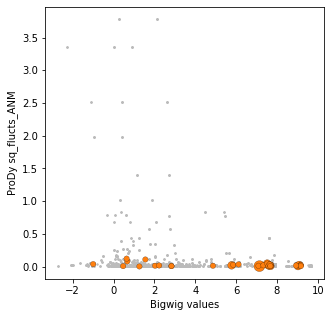

In [67]:
# Then the two results can be plotted
plot_scatter_two_scores(bw_section, anm_section, figsize=(5, 5), show_legend=False, 
                        base_marker_size=30, unmutated_marker_size=2)

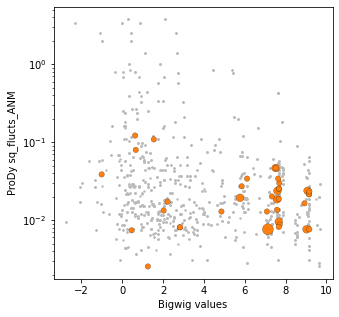

In [68]:
# Can change the axis scaling for one score to make the spread easier to see
plot_scatter_two_scores(bw_section, anm_section, figsize=(5, 5), show_legend=False, plot_yscale='log', 
                       base_marker_size=30, unmutated_marker_size=2)

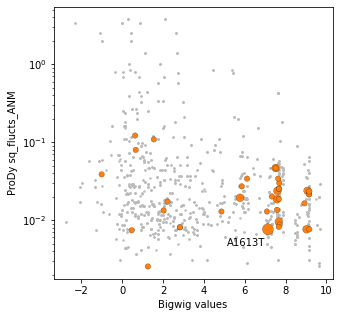

In [69]:
# Want to know the mutation that has a bigwig score of between 7 and 8, a Prody score below 10-2 and is 
# observed at least 3 times?
# To to this, mutations in selected regions of the plot can be annotated
plot_scatter_two_scores(bw_section, anm_section, figsize=(5, 5), show_legend=False, plot_yscale='log', 
                       base_marker_size=30, unmutated_marker_size=2, 
                        # Add the arguments for the annotation
                       annotate_mutations=True, annotate_min_count=3,
                        annotate_xregion=(7, 8), annotate_yregion=(0, 0.01), 
                       annotation_offset=(-2, -0.003))

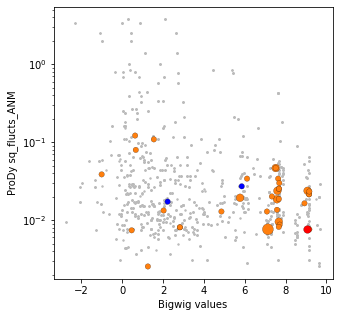

In [70]:
# Can plot lists of mutations in different colours. 
# Here want to see where S1448W and G1414C are, and where the G>A mutation at position 15281535 is. 
# Plot those in blue and red. 
plot_scatter_two_scores(bw_section, anm_section, figsize=(5, 5), show_legend=False, plot_yscale='log', 
                       base_marker_size=30, unmutated_marker_size=2, 
                        # Add the arguments for the mutations to colour
                        mut_lists_to_colour=[['S1448W', 'G1414C'], ['15281535:G>A']], 
                        mut_list_colours=['b', 'r'], mut_list_columns=['aachange', 'ds_mut_id'])

In [71]:
# Can colour regions of the plot based on further scores. Here the beta factors from the 4ZLP structure.
beta_section = d.run_section({'gene': 'NOTCH3', 'start': 1378, 'end': 1640, 'pdb_id':'4ZLP', 'pdb_chain':'A',
                             'included_mutation_types': 'missense',
                             'lookup': ProDyLookup(
                                 metric='beta_factors',
                                 pdb_directory="tests/test_data/",
                                 sifts_directory="tests/test_data/"
                             )})

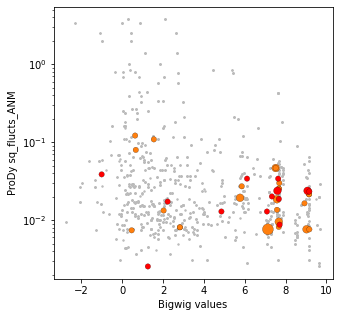

In [72]:
# The observed mutations with a beta factor of between 25 and 30 are now coloured red. 
plot_scatter_two_scores(bw_section, anm_section, 
                        sections_for_colours=[beta_section], score_regions_for_colours=[(25, 30)], 
                        score_region_colours=['r'],
                        figsize=(5, 5), 
                        show_legend=False, plot_yscale='log', 
                       base_marker_size=30, unmutated_marker_size=2)

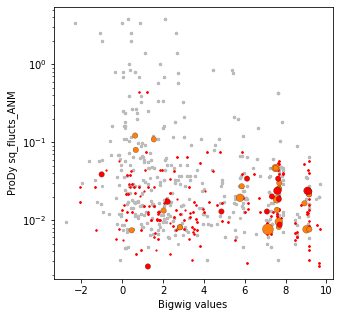

In [73]:
# By setting colour_unmutated_by_scores=True, 
# all mutations, observed or not, with a beta factor of between 25 and 30 are now coloured red. 
plot_scatter_two_scores(bw_section, anm_section, 
                        sections_for_colours=[beta_section], score_regions_for_colours=[(25, 30)], 
                        score_region_colours=['r'], colour_unmutated_by_scores=True,
                        figsize=(5, 5), 
                        show_legend=False, plot_yscale='log', 
                       base_marker_size=30, unmutated_marker_size=5)

## Using Uniprot data

For a quick look for abnormal patterns of mutations in a protein, the mutation locations can be compared to  Uniprot data.  This might reveal an enrichment of mutations in certain domains or on particular features.  

In [74]:
from darwinian_shift import uniprot_exploration

/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


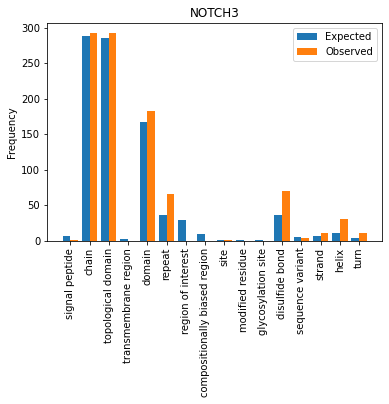

In [75]:
# This looks at the expected and observed mutations in each type of uniprot feature
uni_res = uniprot_exploration(genes='NOTCH3', ds_object=d, plot=True)

In [76]:
# Statistical tests are run for each feature and multiple test correction is run. 
# For example, there is a significant increase in mutations on disulfide bonds
uni_res[[c for c in uni_res.columns if 'disulfide' in c]]

,disulfide bond_expected,disulfide bond_observed,disulfide bond_pvalue,disulfide bond_qvalue
gene,,,,
NOTCH3,36.152611,70,5.763533e-08,4.610826e-07


The domain definitions from Uniprot can also be used to plot the mutation counts per domain

In [77]:
from darwinian_shift import plot_mutation_counts_in_uniprot_features, UniprotLookup

In [78]:
# First make a UniprotLookup object, and run/make a section of mutations
u = UniprotLookup()

# This will load the mutations without running any statistical tests
# Could also use a Section object where the tests have been run
notch3 = d.make_section(gene='NOTCH3')  

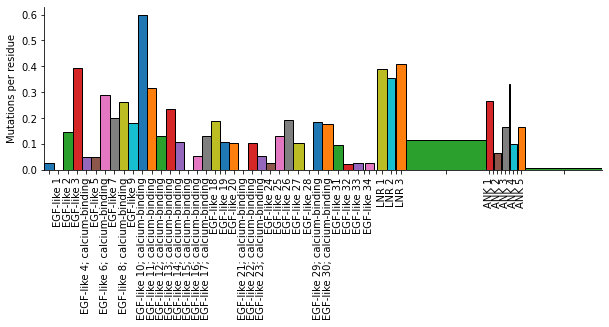

In [80]:
# Then use this UniprotLookup to get the locations of the features to plot and apply this to the analysed section. 
# If the features overlap, the function will raise an error. 
bins, types, descriptions = plot_mutation_counts_in_uniprot_features(notch3, 
                                                                     u.get_uniprot_data(notch3.transcript_id), 
                                        feature_types=['domain', 'repeat'], return_bins=True)

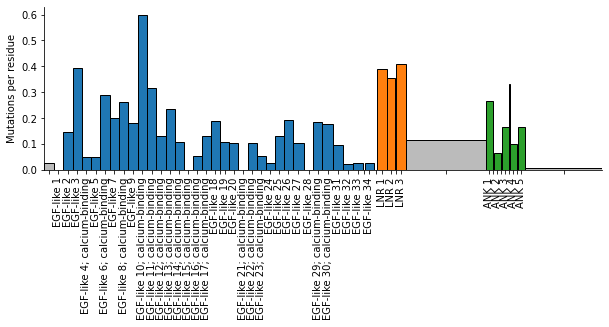

In [81]:
# Can provide the plotting colours. 
# Here, using the feature descriptions to make the colour list
colours = []
for de in descriptions:
    if de is None:  # Not in a one of the Uniprot features selection
        colours.append('#BBBBBB')
    elif 'EGF' in de:
        colours.append('C0')
    elif 'LNR' in de:
        colours.append('C1')
    elif 'ANK' in de:
        colours.append('C2')
plot_mutation_counts_in_uniprot_features(notch3, u.get_uniprot_data(notch3.transcript_id), 
                                        feature_types=['domain', 'repeat'], 
                                        colours=colours)

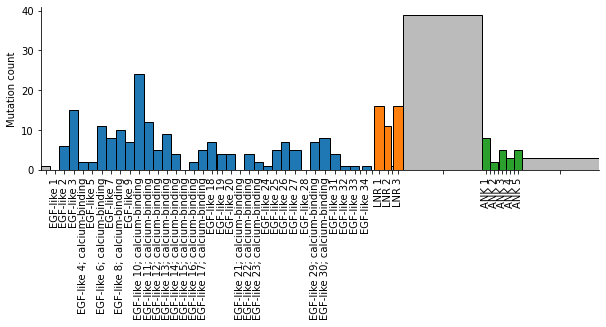

In [82]:
# By default, the number of mutations is divided by the size of the bin. 
# If normalise_by_region_size=False, the raw counts per region are plotted.
plot_mutation_counts_in_uniprot_features(notch3, u.get_uniprot_data(notch3.transcript_id), 
                                        feature_types=['domain', 'repeat'], 
                                         colours=colours,
                                        normalise_by_region_size=False)

In [83]:
# Uniprot can also be used to list available protein structures and chains for a gene transcript
from darwinian_shift import get_pdb_details
get_pdb_details(transcript_id=notch3.transcript_id)

,index,pdb_chain,mutation_flag,title,pdb_id,method,resolution,chains,transcript_id
0,0,A,None,Crystal Structure of Notch3 Negative Regulator...,4ZLP,X-ray,2.48,A/B,ENST00000263388
1,1,B,None,Crystal Structure of Notch3 Negative Regulator...,4ZLP,X-ray,2.48,A/B,ENST00000263388
2,0,A,None,Crystal structure of Notch3 NRR in complex wit...,5CZV,X-ray,3.19,A,ENST00000263388
3,0,A,None,Crystal structure of Notch3 NRR in complex wit...,5CZX,X-ray,2.10,A/B,ENST00000263388
4,1,B,None,Crystal structure of Notch3 NRR in complex wit...,5CZX,X-ray,2.10,A/B,ENST00000263388


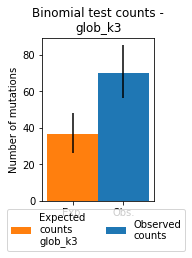

In [84]:
# Uniprot features can also be used to score mutations for a lookup
# Here we can test for enrichment of mutations on disulfide bonds or on glycosylation sites
u = UniprotLookup(feature_types=['disulfide bond', 'glycosylation site'])
notch3_uniprot = d.run_gene('NOTCH3', lookup=u, statistics=BinomTest())
notch3_uniprot.plot_binomial()